In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
df_kir_ = pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/kir_four_random_counts.csv', index_col=0, nrows= 3000)

capture_kits = pd.read_csv('/cellar/users/ramarty/Data/kir/ref/sample.capture.kit', sep='\t')
capture_kits = capture_kits[capture_kits.SHORT_ID.isin(df_kir_.index)]
capture_kits['KIT'].value_counts()
capture_kits.set_index('SHORT_ID', inplace = True)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Agilent Custom     1874
Nimblegen HGSC      471
Nimblegen.SQEZ2     298
Nimblegen hg18      110
Sureselect.38        68
Nimblegen.SQEZ3      31
Name: KIT, dtype: int64

# find the k-mers with the most variation between kits.

## Method
- calculate each kmer count averge for capture kit
- find the most variable average(variance) kmer among kit

- assumption: variations are caused by capture kit, not populational variaion of certain KIR

In [17]:
kmer_sum = pd.DataFrame(index = capture_kits['KIT'].unique(), columns = df_kir_.columns)
# did not calculate Agilent cause it makes memory dead
for c in capture_kits['KIT'].unique():
    indices = capture_kits.loc[capture_kits['KIT'] == c].index.unique()
    kmer_sum.loc[c] = df_kir_.loc[indices].sum(axis =0)/len(indices)

In [18]:
kmer_sum #kmer per sample

,TGGCCCAGCT,GGCCCAGCTC,GCCCAGCTCT,CCCAGCTCTG,CCAGCTCTGT,CAGCTCTGTG,AGCTCTGTGG,GCTCTGTGGT,CTCTGTGGTG,TCTGTGGTGC,...,TCGAAGAACCCCCTCCACTGCCCATCTGAG,GAGCACACAGAATCTGCTACTCCTGCTGAC,GCATCTGGGTGCAACAAAACGTTCCAAGTG,TTGAGGATGCCATTAAGTATTTCAAGGAAA,GCTGAGGGTCCCGCCCCCATGCCCCGTCGA,ATCTGGGTGCAACAAAACGTTCCAAGTGGG,GACGCATAACTGGAGGTGGGATCCACACAG,AACAGCTGGATCTTGCTCAGTCTCTGCCAG,ACTGCCCATCTGAGAGTGCCCAAGACCAGC,TGCTGACTGATAATGAGGCCTGGAACGGAT
Agilent Custom,17.8648,53.2199,57.7504,8.59336,45.5418,8.3527,8.41257,8.54713,31.6052,9.08239,...,0.103734,24.5353,0.114997,20.3225,0.0912863,0.113219,2.92768,9.02253,0.0871369,9.54001
Sureselect.38,24.2647,55.2059,54.1324,18.9412,67.1029,18.3676,19,18.9706,29.9853,21.3529,...,0.235294,16.3235,0,15.7647,0.235294,0,2.51471,2.75,0.176471,6.69118
Nimblegen.SQEZ2,27.395,101.584,46.427,14.3452,41.5445,14.032,13.8541,13.9964,31.0107,14.4235,...,9.38434,13.0641,0.0604982,13.3737,10.1922,0.0640569,0.619217,1.81851,6.879,4.6121
Nimblegen HGSC,24.0639,70.6142,104.715,9.04795,52.5023,6.75114,5.02055,5.16895,21.5639,5.39498,...,47.379,27.0639,0.0799087,27.7283,51.6598,0.0707763,2.54795,5.90183,35.4749,9.78539
Nimblegen hg18,26.0769,90.7596,88.2788,20.6442,110.663,19.4615,19.1635,19.8942,49.5865,21.1827,...,0.759615,41.625,0.134615,42.9038,0.769231,0.125,4.17308,7.79808,0.519231,14.3365
Nimblegen.SQEZ3,22.4333,84.2,86.5,11.1,98.7667,10.1,9.66667,10.1,38.6667,10.5333,...,0.633333,41.4667,0.433333,44.9333,0.733333,0.366667,4.43333,16.7667,0.533333,13.5333


In [19]:
# import k-mers
import json
kmers = {}
ks = [10, 15, 20, 25, 30, 35, 40]
for k in ks:
    with open('/cellar/users/ramarty/Data/kir/kmers/gene_grouped_kmers/{0}.txt'.format(str(k))) as infile:
        g = json.load(infile)
    kmers[k] = g

In [20]:
# which length is the most popular
# which gene's kmer is the most popular
# among top 100 variations in kmer
def kmer_belongs(kmer_list):
    l_dict = {}
    g_dict = {}
    for length in kmers.keys():
        for gene in kmers[length].keys():
            count = len(set(kmer_list).intersection(set(kmers[length][gene])))
        
            if length in l_dict.keys():
                l_dict[length] += count
            else:
                l_dict[length] = count
        
            if gene in g_dict.keys():
                g_dict[gene] += count
            else:
                g_dict[gene] = count
    return(l_dict, g_dict)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plot_kmer_belong(l_dict, g_dict):
    plt.subplot(2, 1, 1)
    plt.bar(np.arange(len(l_dict)), height = l_dict.values())
    plt.xticks(np.arange(len(l_dict)),l_dict.keys())
    plt.xlabel('k-mer length')
    plt.ylabel('Count in top 100 variable k-mers')
    
    plt.subplot(2, 1, 2)
    plt.bar(np.arange(len(g_dict)), height = g_dict.values())
    plt.xticks(np.arange(len(g_dict)),g_dict.keys(), rotation=90)
    plt.xlabel('k-mer belongs to')
    plt.ylabel('Count in top 100 variable k-mers')

# the top 100 k-mers with largest variance **BETWEEN** capture kits
- a lot of them belong to KIR2DL5
- some belong to KIR2DP1, KIR2DL4(anchoring), KIR3DL3(anchoring), KIR3DL2(anchoring)
- these k-mer variation can be due to capturing kits, or populatinoal difference (for example, Agilent might have more Caucasians) but generally we assume this to be the same)

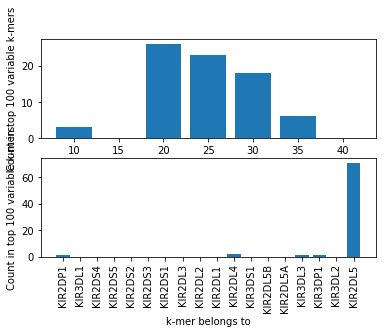

In [24]:
# what are the k-mers with most variation
top_100_var_kmer = kmer_sum.std().sort_values(ascending = False)[:100].index
# which length is the most popular
# which gene's kmer is the most popular
# among top 100 variations in kmer
l_dict, g_dict = kmer_belongs(top_100_var_kmer)
plot_kmer_belong(l_dict, g_dict)

# Top 300 variance k-mer is similar to top 100

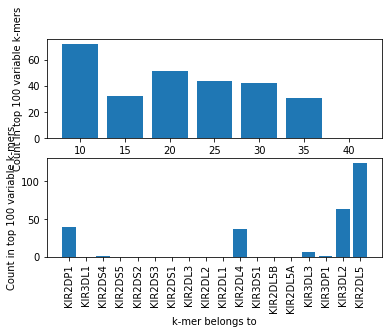

In [25]:
top_300_var_kmer = kmer_sum.std().sort_values(ascending = False)[:300].index
l_dict, g_dict = kmer_belongs(top_300_var_kmer)
plot_kmer_belong(l_dict, g_dict)

# Then I set out to find if any k-mer is UNIVERSALLY lost in certain capture kit?
- universally lost means, within all samples of the capture kit, the column for that k-mer are all 0

Text(0.5, 0.98, 'k-mer lost in all samples within each kit')

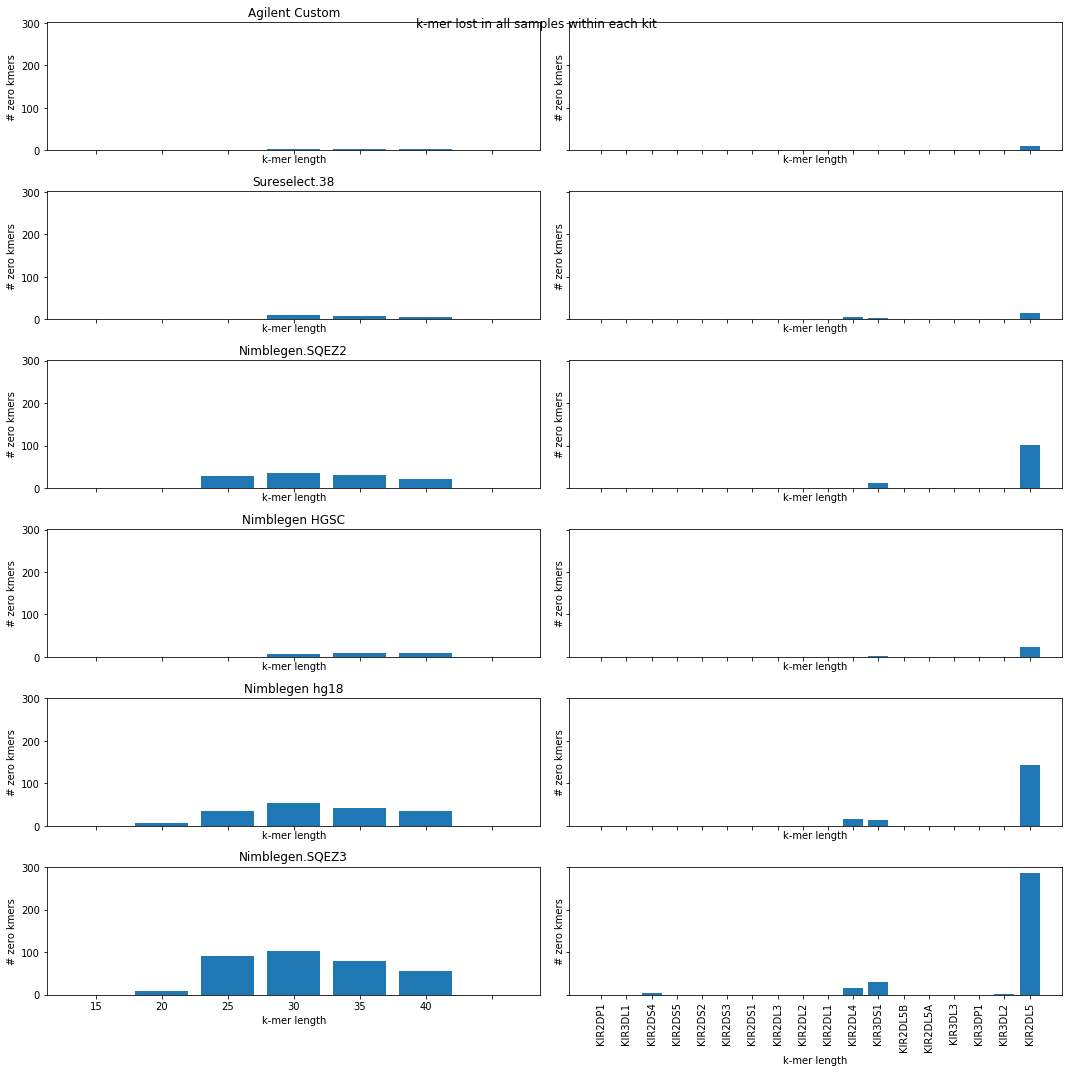

In [54]:
# lost k-mer: find k-mer count 

lost_kmer = kmer_sum.loc[:,kmer_sum.eq(0).any()]
zero_count_per_kit = []
i = 0
fig, ax = plt.subplots(nrows = len(lost_kmer.index), ncols = 2, figsize = (15,15), sharey = True, sharex = 'col')
for kit in lost_kmer.index:
    zeros = lost_kmer.loc[kit].eq(0)
    # count how many zero
    zero_count = zeros.sum()
    zero_count_per_kit.append(zero_count)
    # count which kir they belong to
    zero_kmer = lost_kmer.loc[kit, zeros].index
    l_dict, g_dict = kmer_belongs(zero_kmer)
    
    
    ax[i, 0].bar(np.arange(len(l_dict)), height = list(l_dict.values()))
    ax[i, 0].set_xticklabels(l_dict.keys())
    ax[i, 0].set_xlabel('k-mer length')
    ax[i, 0].set_ylabel('# zero kmers')
    ax[i, 0].title.set_text(kit)
    
    ax[i, 1].bar(np.arange(len(g_dict)), height = list(g_dict.values()))
    ax[i, 1].set_xticks(np.arange(len(g_dict)))
    ax[i, 1].set_xticklabels(g_dict.keys(), rotation = 90)
    ax[i, 1].set_xlabel('k-mer length')
    ax[i, 1].set_ylabel('# zero kmers')
    i+=1
plt.tight_layout()
plt.suptitle('k-mer lost in all samples within each kit')

- The pattern of k-mer loss seems to be similar across kit.
- the `# zero kmers` on y axis as difference is because as the sample size grows, k-mers become unlikely UNIVERSALLY loss. Therefore we see in Agilent there are less universally lost k-mer cause it has the most data.
- No specific pattern of k-mer loss across kit? => I can't say that, it is largely affected by sample size. But at least the general pattern is the same.
- KIR2DL5, the one with greatest variance between kits, has a lot of zeros for many kits. Can that be the contribution to large variance??

# To see each sample's 0 individually.
- if a kit has problem with certain k-mer, it might not be ALL zeros. It can menifest as "having more zeros" comparing to other kits.
- Therefore just looking at **UNIVERSALLY** lost k-mer might be insufficient.
- I decide to count for each k-mer, what % of them are zero for each capture kit.
- By normalizing sample size, now we see how good each kit capture each k-mer

In [55]:
# look at each sample. if 0 ever existed in that k-mer
# the above only takes the average over kit
# lost k-mer: find k-mer count 
zero_count_df = pd.DataFrame(index = capture_kits['KIT'].unique(), columns = df_kir_.columns)
# how many zeros per k-mer per kit
for kit in capture_kits['KIT'].unique():
    kit_id = capture_kits.loc[capture_kits['KIT'] == kit].index.unique()
    
    # slice the df
    slice_df = df_kir_.loc[kit_id]
    for kmer in slice_df.columns:
        zero_count = slice_df[kmer].eq(0).sum() #how many zero for that k-mer
        zero_count_df.loc[kit, kmer] = zero_count

In [59]:
# normalize by sample size
zero_count_df_norm = pd.DataFrame(index = zero_count_df.index, columns = zero_count_df.columns)
for kit in zero_count_df.index:
    zero_count_df_norm.loc[kit] = zero_count_df.loc[kit]/capture_kits['KIT'].value_counts()[kit]

In [87]:
kmer_id = pd.DataFrame(columns = zero_count_df.columns, index = ['length', 'KIR'])
for length in kmers.keys():
        for gene in kmers[length].keys():
            kmer_id.loc['length', kmers[length][gene]] = length
            kmer_id.loc['KIR', kmers[length][gene]] = gene
kmer_id.fillna('other', inplace = True)

In [108]:
def color_call(label):
    network_pal = sns.cubehelix_palette(label.unique().size,
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=np.random.rand())
    network_lut = dict(zip(map(str, label.unique()), network_pal))

    network_colors = label.map(network_lut)
    return(network_colors, network_lut)

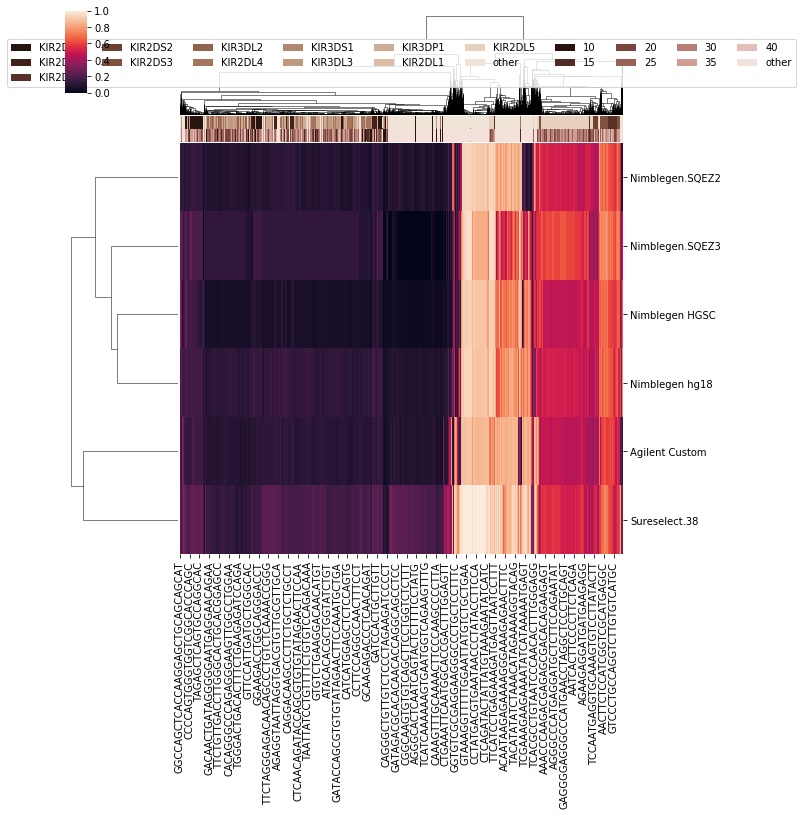

In [116]:
import seaborn as sns

kir_color, kir_dict = color_call(kmer_id.loc['KIR'])
len_color, len_dict = color_call(kmer_id.loc['length'].astype(str))

g = sns.clustermap(zero_count_df_norm.fillna(0), col_colors = [kir_color, len_color])

# generate legend

for label in kir_dict.keys():
    g.ax_col_dendrogram.bar(0, 0, color=kir_dict[label],label=label, linewidth=0)
for label in len_dict.keys():
    g.ax_col_dendrogram.bar(0, 0, color=len_dict[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=10)



## How to look at this figure?
- it's ugly.
- each column in the cluster map is a k-mer.
- Which gene/what length that k-mer belongs to? Please look at the two color bars on top and the **ugly** legend.
- each row is a kit.
- The more yellowish, means the %k-mer =0 in that kit is higher.
- The more purplish, means that %k-mer = 0 is low in that kit.
- kits with a lot of yellow/red --> they have many zeros in their samples --> bad capture.

### Are there difference betweem the capture pattern of kits?
- Yes there are. Look at the right half, notice there are some purple strips within the reddish sea. These are the k-mer preferentially captured by specific kits. The strips for each kit are of different k-mer
- The clustering between kits fits our knowledge --> Nimblegen forms its own cluster.

### Who do those k-mers belong to 
- quite hard to answer as the colorbar at top is hard to distinguish by eye :(
- but we can do it this way


In [124]:
kmer_id.loc['std']=zero_count_df_norm.std()

Text(0, 0.5, 'std of #zeros between kits')

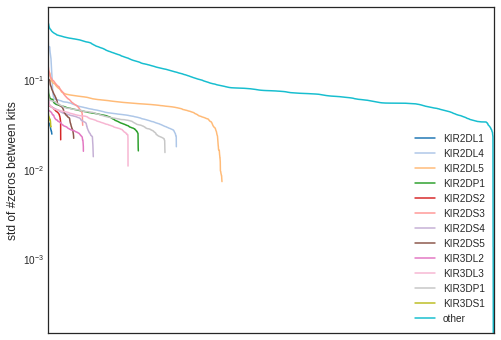

In [176]:
plt.style.use('seaborn-white')

import matplotlib.colors as colors
import matplotlib.cm as cmx
z = range(1,13)
hot = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=13)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

fig, ax = plt.subplots(figsize=(8,6))
i = 0
for name, group in kmer_id.loc[['std', 'KIR']].sort_values(by = 'std', axis = 1, ascending = False).transpose().groupby('KIR'):
    group['std'].plot(label = name, ax=ax, legend = True, logy = True, color=scalarMap.to_rgba(i))
    i += 1

ax.set_xticklabels('')
ax.set_ylabel('std of #zeros between kits')


# most differneces are from
1. other (random genes, 4-mers)
2. a **few** k-mer from KIR2DL4, as they drop very fast
3. KIR2DL5 are constantly large in std. so as KIR2DS3. They are all non-anchroing genes

Text(0, 0.5, 'std of #zeros between kits')

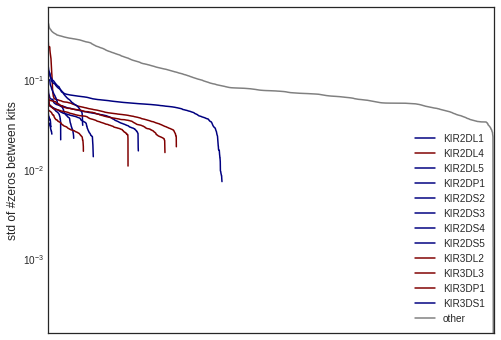

In [180]:
anchor_genes = ['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2']
# difference in anchoring gene? 

fig, ax = plt.subplots(figsize=(8,6))

for name, group in kmer_id.loc[['std', 'KIR']].sort_values(by = 'std', axis = 1, ascending = False).transpose().groupby('KIR'):
    if name in anchor_genes:
        c = 'maroon'
    elif name == 'other':
        c = 'grey'
    else:
        c = 'navy'
    group['std'].plot(label = name, ax=ax, legend = True, logy = True, color=c)


ax.set_xticklabels('')
ax.set_ylabel('std of #zeros between kits')

In [96]:
# save the fat data for reuse
zero_count_df.to_pickle('zero_count_df')
zero_count_df_norm.to_pickle('zero_count_df_norm')

In [170]:
 print(plt.style.available)

['fast', 'seaborn-white', 'seaborn-ticks', 'bmh', 'seaborn-paper', 'dark_background', 'seaborn-pastel', 'seaborn-dark', 'grayscale', 'seaborn-notebook', 'tableau-colorblind10', 'ggplot', 'seaborn-deep', '_classic_test', 'fivethirtyeight', 'seaborn-dark-palette', 'seaborn', 'classic', 'seaborn-muted', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-darkgrid', 'seaborn-whitegrid', 'seaborn-talk', 'Solarize_Light2', 'seaborn-poster']
